## Data and Package Importing

In [1]:
import sklearn.preprocessing as sp
import sys
sys.path.append('../')
from QC import *
sc.settings.set_figure_params(dpi=80)

In [ ]:
# reload fcc module while working
import sys
del sys.modules['QC']
from QC import *

### Mouse Data

In [2]:
train = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad')
test = sc.read_h5ad('../data/3072-AS-2-CTTGTA_S2.h5ad')
#3777-SM-2-CTTGTA_S2.h5ad
#3777-SM-1-GCCAAT_S1.h5ad
test.raw = test

In [3]:
test.X

array([[ 0., 10.,  1., ...,  0.,  0.,  0.],
       [ 0.,  2.,  3., ...,  0.,  0.,  0.],
       [ 0.,  6.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [3]:
%%time

# create new "observations" as percent and mean mito genes
train.var['mito'] = train.var_names.str.contains('mt-') # identify mitochondrial genes
train.obs['mean_mito'] = np.mean(train[:,train.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(train, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# create new "observations" as percent and mean mito genes
test.var['mito'] = test.var_names.str.contains('mt-') # identify mitochondrial genes
test.obs['mean_mito'] = np.mean(test[:,test.var['mito']].X, axis=1) # add average mitochondrial expression to .obs
sc.pp.calculate_qc_metrics(test, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# rank cells by total counts and save as .obs
train.obs['ranked_total_counts'] = np.argsort(train.obs['total_counts'])
test.obs['ranked_total_counts'] = np.argsort(test.obs['total_counts'])

Wall time: 18.4 s


In [4]:
train.obs['set'] = 'train'
test.obs['set'] = 'test'

In [5]:
merge_data = train.concatenate(test) #Merge Train and Test

### Normalize and dimensionality reduction with PCA

In [6]:
%%time
sc.pp.normalize_total(merge_data, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(merge_data) # log1p transformation
sc.pp.scale(merge_data, max_value=10) # scaling by variance and centering to zero for visualization

Wall time: 47.9 s


In [7]:
sc.pp.normalize_total(test, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(test) # log1p transformation
sc.pp.scale(test, max_value=10) # scaling by variance and centering to zero for visualization

In [8]:
sc.tl.pca(test, n_comps=100)

In [17]:
sc.tl.tsne(test, n_pcs=100,n_jobs=-1) # perform tsne and plot results

... storing 'set' as categorical


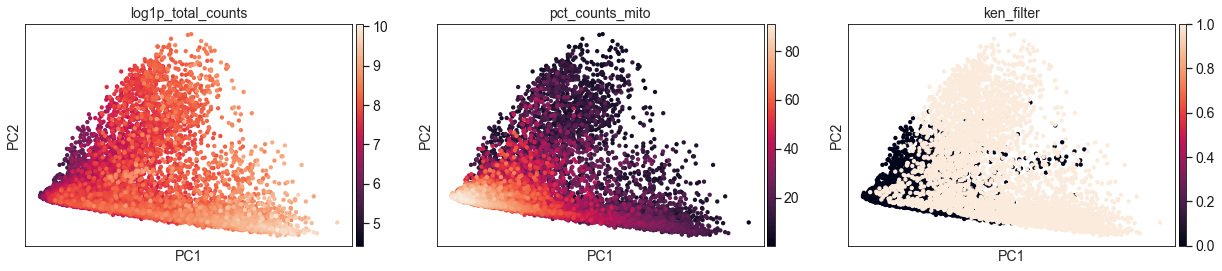

In [10]:
sc.tl.pca(merge_data, n_comps=100) # perform PCA and plot results
sc.pl.pca(merge_data, color=['log1p_total_counts','pct_counts_mito','ken_filter'], ncols=4, size=75)

#### Regular Binary (Self training)

#### Cross Group Binary 

In [11]:
array1 = np.where(merge_data.obs['set']== 'train')
array2 = np.where(merge_data.obs['set']== 'test')
X=merge_data.obsm['X_pca'] 
y=merge_data.obs['ken_filter']

In [12]:
%%time
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial', max_iter=1000)
rf = RandomForestClassifier(n_estimators=1000, max_depth=10,random_state=2)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
gb = GradientBoostingClassifier(n_estimators=100, random_state=0)
lr.fit(X[array1[0]], y[array1[0]])
prediction =lr.predict(X[array2[0]])

Wall time: 4.66 s


In [13]:
test.obs['binary']=prediction

In [14]:
f_positive = 0
f_negative = 0
for i in range(0,len(test)):
    if test.obs['binary'][i]-test.obs['ken_filter'][i]>0:
        f_positive +=1
    if test.obs['binary'][i]-test.obs['ken_filter'][i]<0:
        f_negative +=1
total_acc = 1-((f_positive+f_negative)/len(test))
print('miss-labeled as cell:',f_positive,'; mislabeled as empty:',f_negative,'; Total Accuracy is %0.2f)' % total_acc)

miss-labeled as cell: 285 ; mislabeled as empty: 479 ; Total Accuracy is 0.95)


In [15]:
test.obs['ken_filter'].value_counts()

0    13622
1     2725
Name: ken_filter, dtype: int64

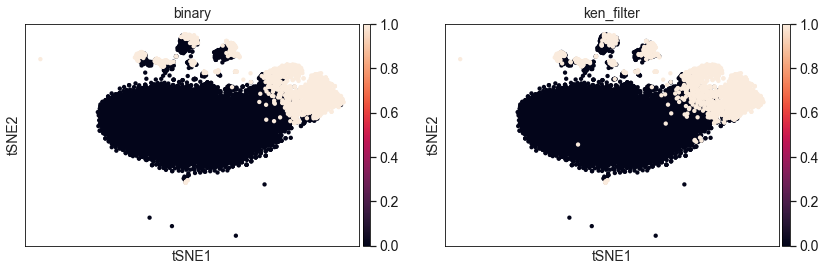

In [19]:
sc.pl.tsne(test, color=['binary','ken_filter'], ncols=4, size=75)

## Clustering

In [30]:
test_filter = test[test.obs['binary']==1,:].copy() # move forward with non-empty droplets
test_filter.X = test_filter.raw.X.copy()

In [31]:
%%time

test_filter2.X = sp.normalize(test_filter2.X, norm = 'l1') # each gene count value is divided by the total number of counts for that respective cell  
transformer = sp.FunctionTransformer(np.log1p,validate=True)
test_filter.X= transformer.transform(test_filter.X*100)
sc.pp.scale(test_filter, max_value=1)

Wall time: 4.85 s


... storing 'set' as categorical


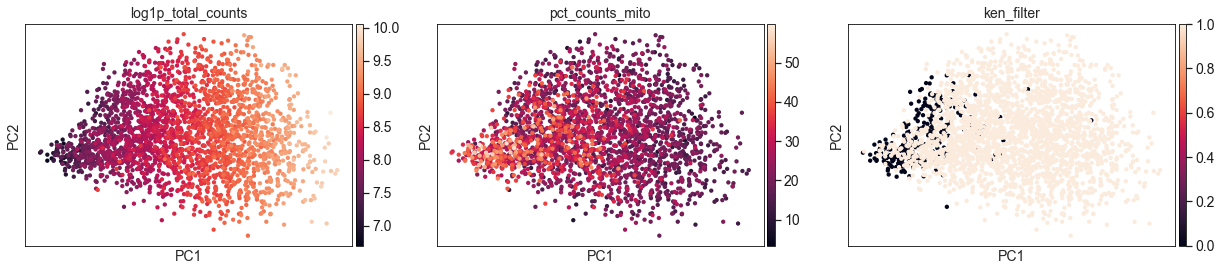

Wall time: 10.8 s


In [32]:
%%time
sc.tl.pca(test_filter, n_comps=100) # perform PCA and plot results
sc.pl.pca(test_filter, color=['log1p_total_counts','pct_counts_mito','ken_filter'], size=75)

In [38]:
%%time
sc.pp.neighbors(test_filter, n_neighbors=50, n_pcs=100, random_state=1)
sc.tl.louvain(test_filter, resolution=1, random_state=20) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters


Wall time: 2.06 s


In [39]:
sc.tl.tsne(test_filter,n_pcs= 100, n_jobs=-1,perplexity=20, random_state=100)

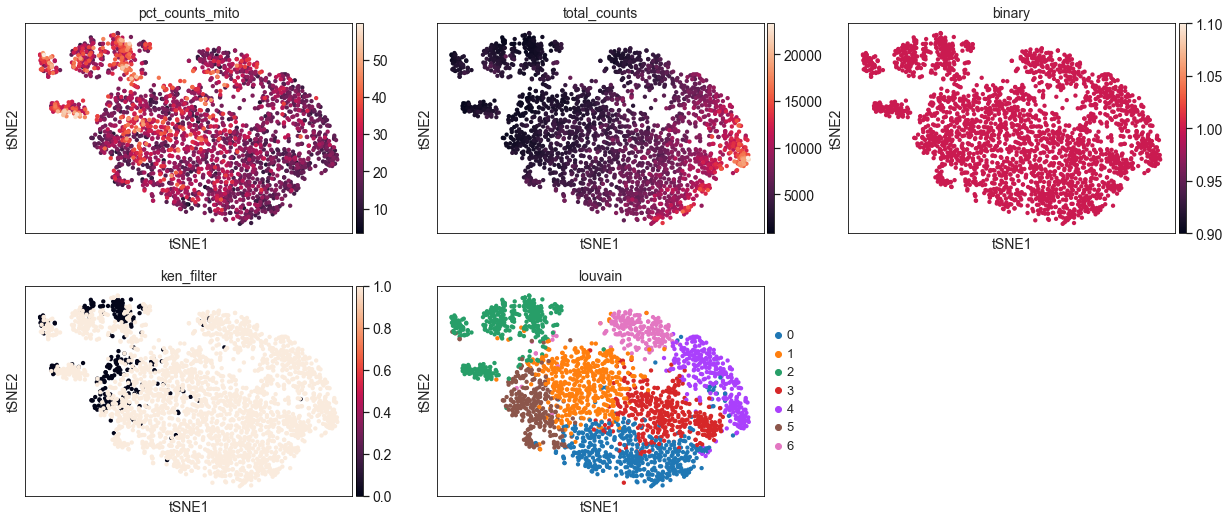

In [40]:

sc.pl.tsne(test_filter,color=['pct_counts_mito','total_counts','binary','ken_filter','louvain'], size=75, ncols=3 )

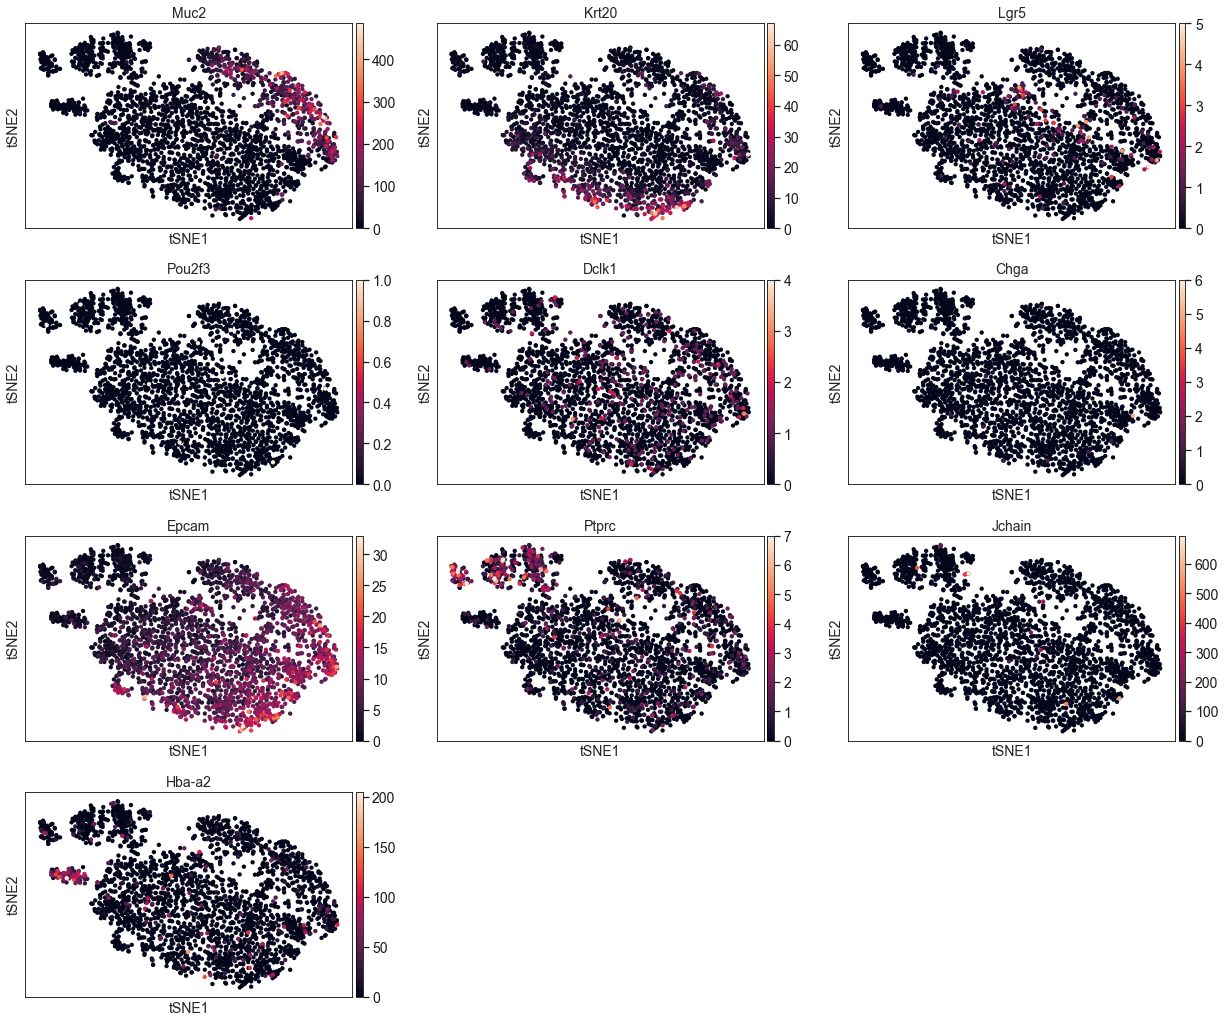

In [36]:
f = sc.pl.tsne(test_filter, color = ['Muc2','Krt20','Lgr5','Pou2f3','Dclk1','Chga','Epcam','Ptprc','Jchain','Hba-a2'], size=75, ncols=3 )
               #save = 'Signature.png')

In [ ]:
%%time
sc.tl.rank_genes_groups(test_filter, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(test_filter, n_genes=3, standard_scale='var', use_raw=False, dendrogram=False)
sc.pl.rank_genes_groups(test_filter, n_genes=25, sharey=False)

In [ ]:
pd.DataFrame(test_filter.uns['rank_genes_groups']['names']).head(20)

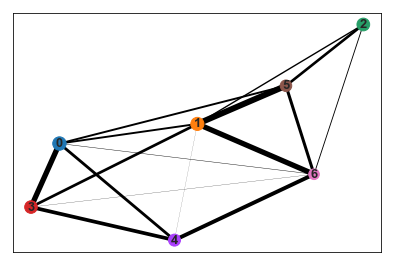

In [41]:
sc.tl.paga(test_filter, groups='louvain')
sc.pl.paga(test_filter)

---
## Ken Filtering

In [19]:
test_filter2 = test[test.obs['ken_filter']==1,:].copy() # move forward with non-empty droplets
test_filter2.X = test_filter2.raw.X.copy()

In [20]:
%%time
test_filter2.X = sp.normalize(test_filter2.X, norm = 'l1') # each gene count value is divided by the total number of counts for that respective cell  
sum(test_filter2.X[1])

Wall time: 1.56 s


0.9999999919200491

In [21]:
transformer = sp.FunctionTransformer(np.log1p,validate=True)
test_filter2.X= transformer.transform(test_filter2.X*100)


... storing 'set' as categorical


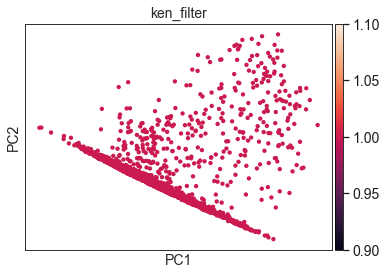

Wall time: 9.05 s


In [22]:
%%time
sc.tl.pca(test_filter2, n_comps=100) # perform PCA and plot results
sc.pl.pca(test_filter2, color=['ken_filter'], size=75)

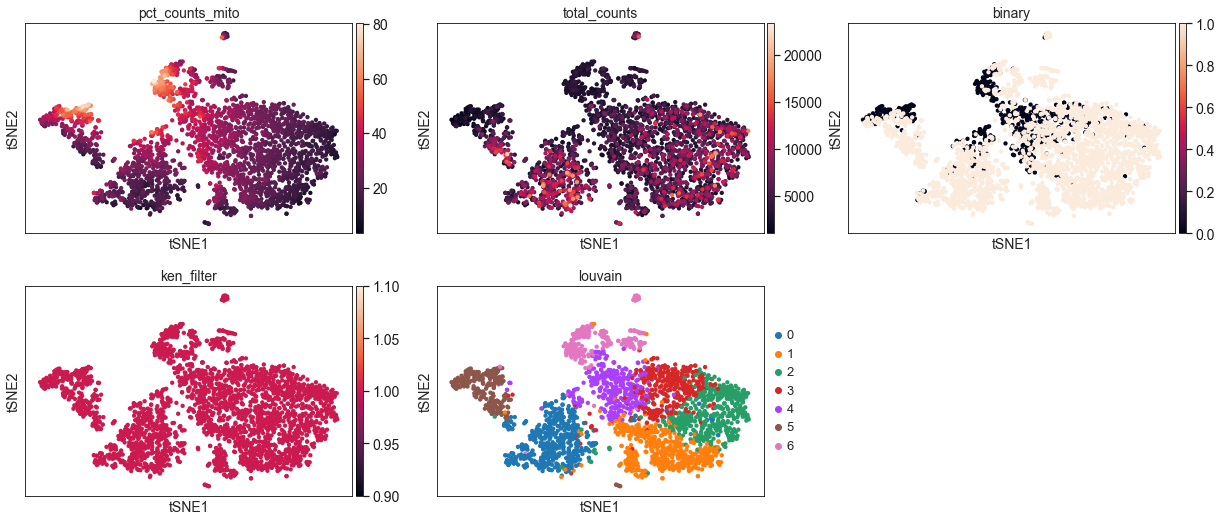

Wall time: 44.4 s


In [42]:
%%time
sc.pp.neighbors(test_filter2, n_neighbors=30, n_pcs=100, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(test_filter2, resolution=1, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters
sc.tl.tsne(test_filter2,n_pcs=100, n_jobs=-1, perplexity = 20, random_state=100)
sc.pl.tsne(test_filter2, color=['pct_counts_mito','total_counts','binary','ken_filter','louvain'], size=75, ncols=3 )

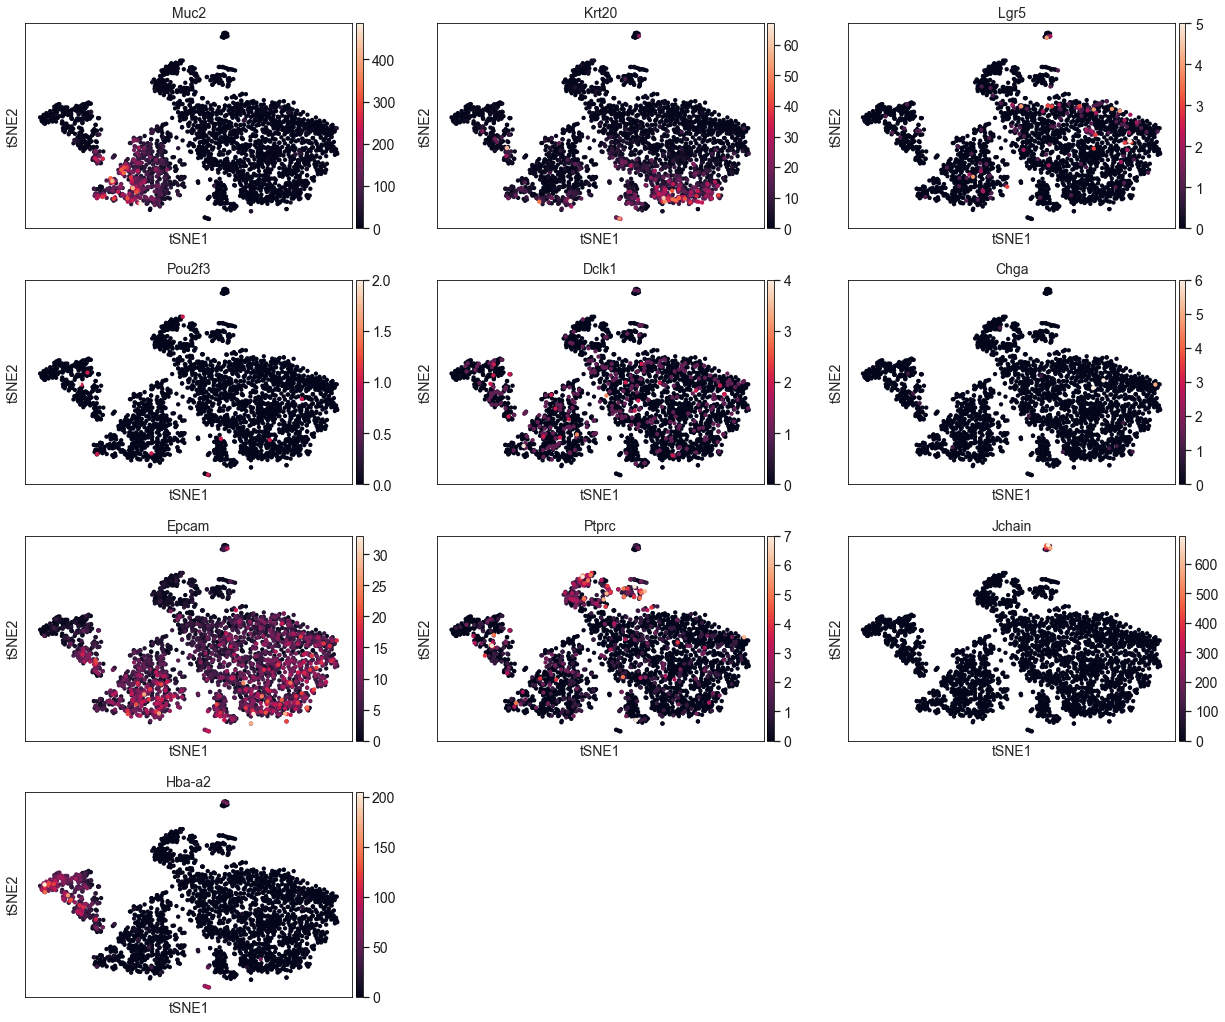

In [37]:
f = sc.pl.tsne(test_filter2, color = ['Muc2','Krt20','Lgr5','Pou2f3','Dclk1','Chga','Epcam','Ptprc','Jchain','Hba-a2'], size=75, ncols=3 )
               #save = 'Signature.png')

In [ ]:
sc.tl.umap(test_filter2)
sc.pl.umap(test_filter2, color=['pct_counts_mito','log1p_total_counts','binary','ken_filter','louvain'], size=75, ncols=3)

In [ ]:
sc.pl.umap(test_filter2, color = ['Muc2','Krt20','Lgr5','Pou2f3','Dclk1','Chga','Epcam','Ptprc','Jchain','Hba-a2'], size=75, ncols=3)

In [ ]:
%%time
sc.tl.rank_genes_groups(test_filter2, 'louvain', method='t-test')
sc.pl.rank_genes_groups_heatmap(test_filter2, n_genes=10, standard_scale='var', use_raw=False, dendrogram=False)
sc.pl.rank_genes_groups(test_filter2, n_genes=25, sharey=False)
pd.DataFrame(test_filter2.uns['rank_genes_groups']['names']).head(10)

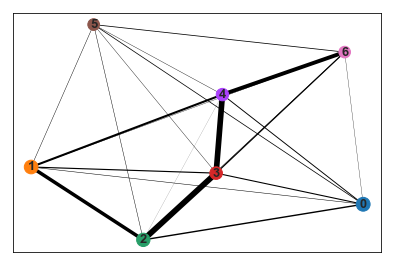

In [43]:
sc.tl.paga(test_filter2, groups='louvain')
sc.pl.paga(test_filter2)

In [ ]:
test3 = sc.read_csv('../data/counts.csv') 

In [ ]:
test3.X = sp.normalize(test3.X, norm = 'l1') # each gene count value is divided by the total number of counts for that respective cell  
transformer = sp.FunctionTransformer(np.log1p,validate=True)
test3.X= transformer.transform(test3.X*100)


In [ ]:
sc.tl.pca(test3, n_comps=100) # perform PCA and plot results
sc.pl.pca(test3, size=75)

In [ ]:
%%time
sc.pp.neighbors(test3, n_neighbors=30, n_pcs=100, random_state=1) # UMAP requires this neighborhood calculation first, will give numba deprecation warnings
sc.tl.louvain(test3, resolution=1, random_state=18) 
#the resolution value here determines the granularity of clustering
#higher resolution = smaller, refined clusters
#lower resolution = larger, coarse grained clusters
sc.tl.tsne(test3,n_pcs=100, n_jobs=-1, perplexity = 20, random_state=100)
sc.pl.tsne(test3, color=['louvain'], size=75, ncols=3 )

In [ ]:
sum(test_filter2.X - test3.X) #before reorder

In [ ]:
sum(test_filter2.X - test3.X)